# Policy Gradient in Reinforcement Learning

As we saw in the [previous tutorial](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/01-q-learning.ipynb), Q-Learning is a baseline method for optimizing generic RL problems, but there exist a lot of problems in stochastic environments - such as, cannot handle the continuous space, empirical greedy exploration, so on and so forth.

In order to overcome, the stochastic distributions are introduced in recent algorithms.<br>
For instance, you will be able to use categorical distribution for discrete action spaces, and Gaussian distribution for even ```Box``` (i.e, continuos) action spaces.<br>
By introducing stochastic space, you don't also need to apply empirical greedy exploration any more.

This tutorial shows the idea of on-policy learning using simple program code.

> Note : Here I'll show you vanilla (plane) policy gradient architecture for the purpose of your beginning, but most algorithms with policy gradient involves advanced other tricks in practice. (See [Actor-Critic](./03-actor-critic.ipynb) or [PPO](./04-ppo.ipynb) examples.)

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

First, please install the required packages and import these modules.<br>
Here we use TensroFlow in order to operate gradient descent.

In [1]:
!pip install torch==1.13.1 --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 MB 4.6 MB/s eta 0:00:00m eta 0:00:010:00:02


In [2]:
!pip install numpy gym matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 3.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 3.2 MB/s eta 0:00:004.1 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 3.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.2 MB/s eta 0:00:002.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 2.3 MB/s eta 0:00:003.9 MB/s eta 0:00:01


In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

/home/nelson404notfound/anaconda3/envs/COCO/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In policy gradient, the action $a$ is picked up by the distribution $P$ which depends on policy $\pi$.<br>
To say more clearly, the distibution of action is $ P(a | \pi_\theta (s)) $, where $ \pi_\theta (s) $ is policy and $\theta$ is parameters for this policy. When the current state $s$ is given, the distribution of action $a$ is determined by this policy.

In this CartPole example, we assume that $P(\cdot)$ is a categorical distribution (because action space is discrete) and $\pi_\theta (s)$ is the following fully-connected network (fcnet).<br>
In this example, the output of this policy $\pi_\theta (s)$ will be logits value, which determines categorical distribution $P(\cdot)$.

![policy](assets/policy.png?raw=true)

> Note : When logits $v_0, v_1$ are given, the probabilities are $\frac{e^{v_0}}{e^{v_0}+e^{v_1}}, \frac{e^{v_1}}{e^{v_0}+e^{v_1}}$ respectively.

First, we implement $\pi_\theta (s)$ (fully-connected network) using PyTorch as follows.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyPi(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.classify = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.classify(outs)
        return logits

policy_pi = PolicyPi().to(device)

In each episode, we consider the following expectation $E_{\pi_\theta}[R]$.
$$ E_{\pi_\theta}[R]=\int_a{R(a) \cdot P(a|\pi_\theta(s))} $$
where $R$ is the cumulative expected rewards $ R = \sum{\gamma r} $, and $\gamma$ is discount rate. (See [Q-Learning](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/01-q-learning.ipynb) for $ \sum{\gamma r} $.)

> Note : To simplify, here I have used $ \int_a R P $, but consider $ \int_{\tau} R P $ for any trajectory $ \tau $.

To get the optimimal $ \theta $ which maximizes $E$, we apply the gradient descent $ \theta_{t+1} \leftarrow \theta_t + \Delta \theta $<br>
where
$$ \Delta \theta = \alpha R \cdot \nabla_{\theta} \log{P(a|\pi_\theta(s))} \;\;\;\;\; (1) $$
and $\alpha$ is learning rate.

<blockquote>
Note : Here I don't go so far, but this formula is derived from the following equation. It's difficult to know $ \nabla E $ directly, but this formula can be easily used on each step in gradient algorithms.

$$ \nabla_{\theta} \int{R(a) \cdot P(a|\pi_\theta(s))} = \int{R(a) \nabla_{\theta}{\log P(a|\pi_\theta(s))} \cdot P(a|\pi_\theta(s))} $$
</blockquote>

As you can see in the equation (1), if the expected reward $R$ is positively large, the probability to take action $a$ in the state $s$ will be increased by modifying $\theta$. On contrary, if the expected reward $R$ is negative, $\theta$ will be changed to decrease the probability to take this action $a$.

As you find, this algorithm will improve a stochastic policy by updating action's policy $ P( \cdot | \pi_\theta (s)) $, not only depending on empirical greedy action sampling such as used in [Q-learning](./01-q-learning.ipynb). This method is then sometimes called **on-policy** learning.<br>
(I'll introduce another approach to operate continuos action by off-policy way in "[DDPG](./05-ddpg.ipynb)".)

To implement this optimization, the training script will become as follows.

I note that cross-entropy error is equivalent to the negative value of this log probability ($ -\log P$) in categorical distribution. So I have used ```torch.nn.functional.cross_entropy()``` instead in the following code.

In [5]:
gamma = 0.99

# Pick up action with above distribution policy_pi
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = policy_pi(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        a = torch.multinomial(probs, num_samples=1)
        # Return
        return a.tolist()[0]

env = gym.make("CartPole-v1")
reward_records = []
opt = torch.optim.AdamW(policy_pi.parameters(), lr=0.001)
for i in range(1000):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    rewards = []
    s, _ = env.reset()
    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Train (optimize parameters)
    #
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    opt.zero_grad()
    logits = policy_pi(states)
    # Calculate negative log probability (-log P) as loss.
    # Cross-entropy loss is -log P in categorical distribution. (see above)
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    loss = -log_probs * cum_rewards
    loss.sum().backward()
    opt.step()

    # Record total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, sum(rewards)), end="\r")
    reward_records.append(sum(rewards))

print("\nDone")
env.close()

/home/nelson404notfound/anaconda3/envs/COCO/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run episode999 with rewards 282.0
Done


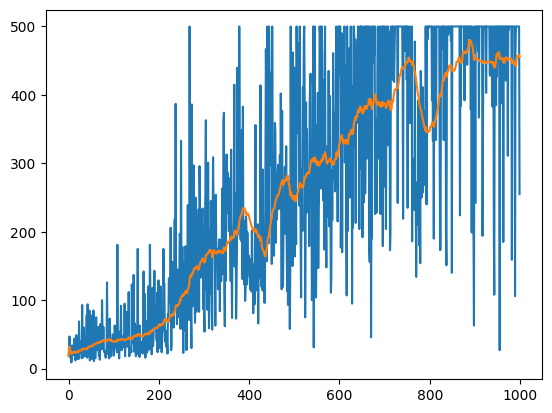

In [6]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
plt.plot(reward_records)
plt.plot(average_reward)

Today the vanilla policy gradient (discussed here) is not used in practice, and this example will then be only for experimental purpose.<br>
In the [next example](./03-actor-critic.ipynb), we will improve this example for stable convergence.